In [1]:
import timeit
import import_ipynb
from RecombHistory import *
plt.rcParams['font.size'] = 12.0

from scipy.integrate import solve_ivp
from scipy.interpolate import CubicSpline
from scipy.interpolate import RectBivariateSpline

# Constants
ainit = 1.0e-8
xinit = np.log(ainit)
x_end = np.log(1.0)

nk = 100
ketamax = 3000.0
#kmin = 1.0/(η_spline(0.0)[0])#/m2Mpc)#7.256e-5
#kmax = ketamax/(η_spline(0.0)[0])#/m2Mpc)#*m2Mpc#.22068
kmin = .1*H0/c
kmax = 1.0e3*H0/c
#ks = np.linspace(kmin, kmax, nk, endpoint=True)

#ks = np.exp(np.linspace(np.log(kmin), np.log(kmax), num=nk))

ks = np.zeros(nk)
for i in range(nk):
    ks[i] = kmin + (kmax - kmin)*(i/100.0)**2.0
    
lmaxint = 6
npar = 6 + lmaxint

ntotal = 1000

importing Jupyter notebook from RecombHistory.ipynb
importing Jupyter notebook from BackgroundCosmology.ipynb
The surface of last scattering occured at x_* = -6.98 and z_* = 1068.80.

The half-way point of recombination occured at x_r = -7.16 and z_r = 1291.14.

Using only the Saha equation, the half-way point of recombination occured at x_r = -7.23 and z_r = 1383.57.



In [2]:
print('kmin/max:         ', kmin, kmax)
print('kmin/max no m2Mpc:', 1.0/(η_spline(0.0)[0]), ketamax/(η_spline(0.0)[0]))
xstartrec = -np.log(1.0 + 1630.4)
print('x > x start rec: ', xstartrec)

x = -7.3
print('x init:', xinit)
dτ = τ2spl(x)[0]
hp = getHPrime(x)
print('abs dtau < 10:', abs(dτ))
print('abs ck/hpdt > .1:', abs(c*ketamax/(η_spline(0.0)[0])/(hp*dτ)))

kmin/max:          7.567046735924967e-28 7.567046735924967e-24
kmin/max no m2Mpc: 2.4412359147282816e-27 7.323707744184845e-24
x > x start rec:  -7.39719382086648
x init: -18.420680743952367
abs dtau < 10: 200.5220541613637
abs ck/hpdt > .1: 0.18915069181512464


In [3]:
# Returns the time at which tight coupling ends.
# Either when (dτ < 10) OR (c*k/(Hp*dt) > .1) OR (x > x(recomb start))
def getTCtime(k):
    xstartrec = -np.log(1.0 + 1630.4)
    x = xinit
    
    #nn = 1000
    #i = -1
    
    while x < xstartrec:
        x = x + 1.0e-3
        
        #i += 1
        #x = xinit + i*(0 - xinit)/nn
        
        
        hp = getHPrime(x)
        dτ = τ2spl(x)[0]
        
        if ( ((abs(dτ) < 10.0) and (abs(c*k/(hp*dτ)) > .1)) or (x > xstartrec) ):
            xtc = x
            break
            
    return xtc

In [4]:
def yTCderivs(x, t):
    dydx = np.zeros(7)
    
    k0 = kcurrent
    
    hp = getHPrime(x)
    dhp = getdHPrime(x)
    
    dτ = τ2spl(x)[0]
    ddτ = τ22spl(x)[0]
    
    R = 4.0*Ωr/(3.0*Ωb*np.exp(x))
    Θ2 = -20.0*c*k0*ytc[6]/(45.0*hp*dτ)
    ψ = -ytc[4] - 12.0*H0**2.0*Ωr*Θ2/(c**2.0*k0**2.0*np.exp(2.0*x))
    
    # δ  = [0]
    # δb = [1]
    # v  = [2]
    # vb = [3]
    # dΦ = [4]
    # θ0 = [5]
    # θ1 = [6]
    
    # dΦ
    dydx[4] = ψ - (c**2.0*k0**2.0*ytc[4]/(3.0*hp**2.0)) + (H0**2.0/(2.0*hp**2.0))*(Ωm*ytc[0]/np.exp(x) + Ωb*ytc[1]/np.exp(x) + 4.0*Ωr*ytc[5]/np.exp(2.0*x))
    
    # dθ0
    dydx[5] = -c*k0*ytc[6]/hp - dydx[4]
    
    q = (-((1.0 - R)*dτ + (1.0 + R)*ddτ)*(3.0*ytc[6] + ytc[3]) - (c*k0/hp)*ψ + (1.0 - dhp/hp)*(c*k0/hp)*(-ytc[5] + 2.0*Θ2) - ((c*k0/hp)*dydx[5]))/((1.0 + R)*dτ + (dhp/hp) - 1.0)
    
    # dvb
    dydx[3] = (-ytc[3] - c*k0*ψ/hp + R*(q + c*k0*(-ytc[5] + 2.0*Θ2)/hp - c*k0*ψ/hp))/(1.0 + R)
    
    #dθ1
    dydx[6] = (q - dydx[3])/3.0
    
    # dv
    dydx[2] = -ytc[2] - c*k0*ψ/hp
    
    # dδ
    dydx[0] = c*k0*ytc[2]/hp - 3.0*dydx[4]
        
    # dδb
    dydx[1] = c*k0*ytc[3]/hp - 3.0*dydx[4]
    
    return dydx

In [5]:
def yderivs(x, t):
    dydx = np.zeros(npar)
    
    k0 = kcurrent
    
    hp = getHPrime(x)
    dhp = getdHPrime(x)
    
    dτ = τ2spl(x)[0]
    ddτ = τ22spl(x)[0]
    
    R = 4.0*Ωr/(3.0*Ωb*np.exp(x))
    ψ = -y[4] - 12.0*H0**2.0*Ωr*y[7]/(c**2.0*k0**2.0*np.exp(2.0*x))
    
    # δ  = [0]
    # δb = [1]
    # v  = [2]
    # vb = [3]
    # Φ  = [4]
    # θ0 = [5]
    # θ1 = [6]
    # Θl = [7->11]
    
    # dΦ
    dydx[4] = ψ - c**2.0*k0**2.0*y[4]/(3.0*hp**2.0) + (H0**2.0/(2.0*hp**2.0))*(Ωm*y[0]/np.exp(x) + Ωb*y[1]/np.exp(x) + 4.0*Ωr*y[5]/np.exp(2.0*x))
    
    # dδ
    dydx[0] = c*k0*y[2]/hp - 3.0*dydx[4]

    # dδb
    dydx[1] = c*k0*y[3]/hp - 3.0*dydx[4]
    
    # dv
    dydx[2] = -y[2] - c*k0*ψ/hp

    # dvb
    dydx[3] = -y[3] - c*k0*ψ/hp + dτ*R*(3.0*y[6] + y[3])
    
    # dθ0
    dydx[5] = -c*k0*y[6]/hp - dydx[4]

    # dθ1
    dydx[6] = c*k0*y[5]/(3.0*hp) - 2.0*c*k0/(3.0*hp)*y[7] + c*k0*ψ/(3.0*hp) + dτ*(y[6] + (1.0/3.0)*y[3])
    
    # dΘ2->5
    for l in range(2, lmaxint):
        dydx[5 + l] = l*c*k0*y[5 + l - 1]/((2.0*l + 1.0)*hp) - (l + 1.0)*c*k0*y[5 + l + 1]/((2.0*l + 1.0)*hp) + dτ*(y[5 + l] -(1.0/10.0)*y[7])
    
    # dΘ6
    dydx[npar - 1] = c*k0*y[npar - 2]/hp - c*(lmaxint + 1)*y[npar - 1]/(hp*η_spline(x)) + dτ*y[npar - 1]
    
    return dydx

In [6]:
def yderivs_C_l(x, y):
    dydx = np.zeros(npar)
    
    k0 = kcurrent
    
    hp = getHPrime(x)
    dhp = getdHPrime(x)
    
    dτ = τ2spl(x)[0]
    ddτ = τ22spl(x)[0]
    
    R = 4.0*Ωr/(3.0*Ωb*math.exp(x))
    ψ = -y[4] - 12.0*H0**2.0*Ωr*y[7]/(c**2.0*k0**2.0*np.exp(2.0*x))
    
    # δ  = [0]
    # δb = [1]
    # v  = [2]
    # vb = [3]
    # Φ  = [4]
    # θ0 = [5]
    # θ1 = [6]
    # Θl = [7->11]
    
    # dΦ
    dydx[4] = ψ - c**2.0*k0**2.0*y[4]/(3.0*hp**2.0) + (H0**2.0/(2.0*hp**2.0))*(Ωm*y[0]/np.exp(x) + Ωb*y[1]/np.exp(x) + 4.0*Ωr*y[5]/np.exp(2.0*x))
    
    # dδ
    dydx[0] = c*k0*y[2]/hp - 3.0*dydx[4]

    # dδb
    dydx[1] = c*k0*y[3]/hp - 3.0*dydx[4]
    
    # dv
    dydx[2] = -y[2] - c*k0*ψ/hp

    # dvb
    dydx[3] = -y[3] - c*k0*ψ/hp + dτ*R*(3.0*y[6] + y[3])
    
    # dθ0
    dydx[5] = -c*k0*y[6]/hp - dydx[4]

    # dθ1
    dydx[6] = c*k0*y[5]/(3.0*hp) - 2.0*c*k0/(3.0*hp)*y[7] + c*k0*ψ/(3.0*hp) + dτ*(y[6] + (1.0/3.0)*y[3])
    
    # dΘ2->5
    for l in range(2, lmaxint):
        dydx[5 + l] = l*c*k0*y[5 + l - 1]/((2.0*l + 1.0)*hp) - (l + 1.0)*c*k0*y[5 + l + 1]/((2.0*l + 1.0)*hp) + dτ*(y[5 + l] -(1.0/10.0)*y[7])
    
    # dΘ6
    dydx[npar - 1] = c*k0*y[npar - 2]/hp - c*(lmaxint + 1)*y[npar - 1]/(hp*η_spline(x)) + dτ*y[npar - 1]
    
    return dydx

In [7]:
def source_function():
    S = np.zeros(shape = (n_grid, nk))
    
    for i in range(n_grid):
        g = gspl(x_grid[i])[0]
        dg = g2spl(x_grid[i])[0]
        ddg = g22spl(x_grid[i])[0]
        τ = τspl(x_grid[i])[0]
        dτ = τ2spl(x_grid[i])[0]
        ddτ = τ22spl(x_grid[i])[0]
        hp = getHPrime(x_grid[i])
        dhp = getdHPrime(x_grid[i])
        ddhhp = .5*H0**2.0*((Ωb + Ωm)/np.exp(x_grid[i]) + 4.0*Ωr/np.exp(2.0*x_grid[i]) + 4.0*ΩΛ*np.exp(2.0*x_grid[i]))
    
        for j in range(nk):
            Π = Θ[n_grid + i, 2, j]
            dΠ = dΘ[i, 2, j]
            ddΠ = .4*c*ks[j]*(-dhp*Θ[n_grid + i, 1, j]/hp + dΘ[i, 1, j])/hp + .3*(ddτ*Π + dτ*dΠ) - (.6*c*ks[j]/hp)*((-dhp/hp)*Θ[n_grid + i, 3, j] + dΘ[i, 3, j])
            
            part1 = g*(Θ[n_grid + i, 0, j] + Ψ[n_grid + i, j] + Π/4.0)
            part2 = np.exp(-τ)*(dΨ[i, j] - dΦ[i, j])
            part3 = -(1.0/(c*ks[j]))*(g*vb[n_grid + i, j]*dhp + g*hp*dvb[i, j] + hp*vb[n_grid + i, j]*dg)
            part4 = ((3.0/4.0)/(c**2.0*ks[j]**2.0))*(ddhhp*g*Π + 3.0*hp*dhp*(dg*Π + g*dΠ) + hp**2.0*(ddg*Π + 2.0*dg*dΠ + g*ddΠ))
            
            S[i, j] = part1 + part2 + part3 + part4
        
    ks_high_res = np.exp(np.linspace(np.log(kmin), np.log(kmax), num=n_high_res))
        
    xstartrec = -np.log(1.0 + 1630.4)
    x_grid_high_res = np.linspace(xstartrec, x_end, n_high_res, endpoint=True)
        
        
    S_spl = RectBivariateSpline(x_grid_high_res, ks_high_res, S)
        
    return S_spl, x_high_res, ks_high_res

In [8]:
# Initialize and solve the Boltzmann and Einstein equations
Θ = np.zeros(shape=(ntotal, lmaxint, nk))
dΘ = np.zeros(shape=(ntotal, lmaxint, nk))

δ = np.zeros(shape=(ntotal, nk))
δb = np.zeros(shape=(ntotal, nk))

v = np.zeros(shape=(ntotal, nk))
vb = np.zeros(shape=(ntotal, nk))
dvb = np.zeros(shape=(ntotal, nk))

Φ = np.zeros(shape=(ntotal, nk))
dΦ = np.zeros(shape=(ntotal, nk))

Ψ = np.zeros(shape=(ntotal, nk))
dΨ = np.zeros(shape=(ntotal, nk))

# Set up initial conditions for Boltzmann and Einstein equations
for i in range(nk):
    
    Φ[0, i] = 1.0
    
    δ[0, i] = (3.0/2.0)*Φ[0, i]
    δb[0, i] = δ[0, i]
    
    v[0, i] = c*ks[i]*Φ[0, i]/(2.0*getHPrime(xinit))
    vb[0, i] = v[0, i]
    
    Θ[0, 0, i] = (1.0/2.0)*Φ[0, i]
    Θ[0, 1, i] = -c*ks[i]*Φ[0, i]/(6.0*getHPrime(xinit))
    Θ[0, 2, i] = -20.0*c*ks[i]*Θ[0, 1, i]/(45.0*getHPrime(xinit)*τ2spl(xinit)[0])
    
    for l in range(3, lmaxint):
        Θ[0, l, i] = -l*c*ks[i]*Θ[0, l - 1, i]/((2.0*l + 1.0)*getHPrime(xinit)*τ2spl(xinit)[0])
        
    Ψ[0, i] = -1.0#-Φ[0, i] - 12.0*Ωr*Θ[0, 2, i]*H0/(c*ks[i]*np.exp(xinit))
    
    '''
    Ψ[0, i] = -1.0/(3.0/2.0)
    Φ[0, i] = -Ψ[0, i]
    
    δ[0, i] = (-3.0/2.0)*Ψ[0, i]
    δb[0, i] = δ[0, i]
    
    v[0, i] = -c*ks[i]*Ψ[0, i]/(2.0*getHPrime(xinit))
    vb[0, i] = v[0, i]
    
    Θ[0, 0, i] = (-1.0/2.0)*Ψ[0, i]
    Θ[0, 1, i] = c*ks[i]*Ψ[0, i]/(6.0*getHPrime(xinit))
    
    Θ[0, 2, i] = -20.0*c*ks[i]*Θ[0, 1, i]/(45.0*getHPrime(xinit)*τ2spl(xinit)[0])
    
    for l in range(3, lmaxint):
        Θ[0, l, i] = -l*c*ks[i]*Θ[0, l - 1, i]/((2.0*l + 1.0)*getHPrime(xinit)*τ2spl(xinit)[0])
    '''

In [21]:
start = timeit.default_timer()

y = np.zeros(npar)
ytc = np.zeros(7) #y tight coupling - ytc

#x_grid_during = np.linspace(xstart, XEND, GRID_DURING)
#x_grid_after = np.linspace(XEND, X0, GRID_AFTER, endpoint=True)
x_grid = np.linspace(xinit, x_end, ntotal)

ntight = 500

# Propogate each k-mode independently
for k in range(nk):
    kcurrent = ks[k]
    
    ytc[0] = δ[0, k]
    ytc[1] = δb[0, k]
    ytc[2] = v[0, k]
    ytc[3] = vb[0, k]
    ytc[4] = Φ[0, k]
    ytc[5] = Θ[0, 0, k]
    ytc[6] = Θ[0, 1, k]
    
    # Find the time at which tight couplint (TC) is assumed
    #  and integrate equations to that time
    xtc = getTCtime(kcurrent)
    
    xtight = np.linspace(xinit, xtc, ntight)
    x_full = np.linspace(xtc, x_end, 1000 - ntight, endpoint=True)
    
    if k%10==0:
        print('------------------------------')
        print('k:', k)
        print('xtc:', xtc)

    sol_tight = solve_ivp(yTCderivs, [xinit, xtc], ytc, t_eval=xtight, rtol=1e-11, atol=1e-11)
    
    y_after_tc = sol_tight.y[:, -1]
    
    for i in range(1, ntight):
        Θ[i, 2, k] = -20.0*c*kcurrent*sol_tight.y[6, i]/(45.0*getHPrime(xtight[i])*τ2spl(xtight[i])[0]) # I don't think I need this
        Ψ[i, k] = -sol_tight.y[4, i] - 12.0*H0**2.0*Ωr*Θ[i, 2, k]/(c**2.0*kcurrent**2.0*np.exp(2.0*xtight[i]))
        
    for j in range(7):
        y[j] = y_after_tc[j]
        
    # Θ2
    y[7] = -20.0*c*kcurrent*y[6]/(45.0*getHPrime(xtc)*τ2spl(xtc)[0])
    
    for l in range(2, lmaxint):
        y[6 + l] = -l*c*kcurrent*y[6 + l - 1]/((2.0*l + 1)*getHPrime(xtc)*τ2spl(xtc)[0])
        
    
    sol_full = solve_ivp(yderivs, [xtc, x_end], y, t_eval=x_full, rtol=1e-11, atol=1e-11)
    
    '''
    y[7] = -20.0*c*kcurrent*y[6]/(45.0*getHPrime(xtc)*τ2spl(xtc)[0])
    
    for l in range(2, lmaxint):
        y[6 + l] = -l*c*kcurrent*y[6 + l - 1]/((2.0*l + 1)*getHPrime(xtc)*τ2spl(xtc)[0])
    '''
    
    for i in range(len(x_full)):
        Ψ[ntight + i, k] = -sol_full.y[4, i] - 12.0*H0**2.0*Ωr*sol_full.y[7, i]/(c**2.0*kcurrent**2.0*math.exp(2.0*x_full[i]))
        #Θ[ntight + i, 2, k] =  sol_full.y[7, i]
        
    '''    
    for i in range(len(x_full)):
        
        deriv_C_ls = yderivs_C_l(x_full[i], y)#solve_ivp(yderivs, [xtc, xtc], y, rtol=1e-11, atol=1e-11)

        dΦ[i, k] = deriv_C_ls[4]
        dvb[i, k] = deriv_C_ls[3]
        dΘ[i, :, k] = deriv_C_ls[6:npar]
        dΨ[i, k] = -dΦ[0, k] + 12.0*H0**2.0*Ωr*Θ[i, 2, k]/(c**2.0*kcurrent**2.0*np.exp(2.0*x_full[i]))
    '''
    
    cur_δ = np.concatenate((sol_tight.y[0], sol_full.y[0]))
    cur_δb = np.concatenate((sol_tight.y[1], sol_full.y[1]))
    cur_v = np.concatenate((sol_tight.y[2], sol_full.y[2]))
    cur_vb = np.concatenate((sol_tight.y[3], sol_full.y[3]))
    cur_Φ = np.concatenate((sol_tight.y[4], sol_full.y[4]))
    cur_Θ0 = np.concatenate((sol_tight.y[5], sol_full.y[5]))
    cur_Θ1 = np.concatenate((sol_tight.y[6], sol_full.y[6]))
    
    δ[:, k] = cur_δ
    δb[:, k] = cur_δb
    v[:, k] = cur_v
    vb[:, k] = cur_vb
    Φ[:, k] = cur_Φ
    Θ[:, 0, k] = cur_Θ0
    Θ[:, 1, k] = cur_Θ1
    
stop = timeit.default_timer()
print('Time:', stop - start)

δ_spl = RectBivariateSpline(x_grid, ks, δ)
δb_spl = RectBivariateSpline(x_grid, ks, δb)
v_spl = RectBivariateSpline(x_grid, ks, v)
vb_spl = RectBivariateSpline(x_grid, ks, vb)
Φ_spl = RectBivariateSpline(x_grid, ks, Φ)
Ψ_spl = RectBivariateSpline(x_grid, ks, Ψ)
Θ0_spl = RectBivariateSpline(x_grid, ks, Θ[:, 0, :])
Θ1_spl = RectBivariateSpline(x_grid, ks, Θ[:, 1, :])
#Θ2_spl = RectBivariateSpline(x_grid, ks, Θ[:, 2, :])

------------------------------
k: 0
xtc: -7.396680743953642


<string>:7: RuntimeWarning: overflow encountered in exp
<string>:10: RuntimeWarning: overflow encountered in exp
<string>:10: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Alex\AppData\Local\Temp/ipykernel_6272/3011667165.py:14: RuntimeWarning: overflow encountered in exp
  ψ = -ytc[4] - 12.0*H0**2.0*Ωr*Θ2/(c**2.0*k0**2.0*np.exp(2.0*x))
C:\Users\Alex\AppData\Local\Temp/ipykernel_6272/3011667165.py:25: RuntimeWarning: overflow encountered in exp
  dydx[4] = ψ - (c**2.0*k0**2.0*ytc[4]/(3.0*hp**2.0)) + (H0**2.0/(2.0*hp**2.0))*(Ωm*ytc[0]/np.exp(x) + Ωb*ytc[1]/np.exp(x) + 4.0*Ωr*ytc[5]/np.exp(2.0*x))


------------------------------
k: 10
xtc: -7.396680743953642


<string>:10: RuntimeWarning: overflow encountered in double_scalars
C:\Users\Alex\AppData\Local\Temp/ipykernel_6272/3011667165.py:30: RuntimeWarning: invalid value encountered in double_scalars
  q = (-((1.0 - R)*dτ + (1.0 + R)*ddτ)*(3.0*ytc[6] + ytc[3]) - (c*k0/hp)*ψ + (1.0 - dhp/hp)*(c*k0/hp)*(-ytc[5] + 2.0*Θ2) - ((c*k0/hp)*dydx[5]))/((1.0 + R)*dτ + (dhp/hp) - 1.0)


------------------------------
k: 20
xtc: -7.396680743953642
------------------------------
k: 30
xtc: -7.396680743953642
------------------------------
k: 40
xtc: -7.396680743953642
------------------------------
k: 50
xtc: -7.396680743953642
------------------------------
k: 60
xtc: -7.396680743953642
------------------------------
k: 70
xtc: -7.396680743953642
------------------------------
k: 80
xtc: -7.396680743953642
------------------------------
k: 90
xtc: -7.396680743953642
Time: 47.1803365589999


In [22]:
def plot(kvals):
    #kmpc = '{:.3g}'.format(kval*(1.0e6*3.08567758e16))
    #data_δ = δ_spl(x_grid, kval)[:, 0]
    #data_δb = δb_spl(x_grid, kval)[:, 0]
    #data_v = v_spl(x_grid, kval)[:, 0]
    #data_vb = vb_spl(x_grid, kval)[:, 0]
    #data_Φ = Φ_spl(x_grid, kval)[:, 0]
    #data_Ψ = Ψ_spl(x_grid, kval)[:, 0]
    #data_Θ0 = Θ0_spl(x_grid, kval)[:, 0]
    #data_Θ1 = Θ1_spl(x_grid, kval)[:, 0]
    #data_Θ2 = Θ2_spl(x_grid, kval)[:, 0]
    
    h = .7
    
    clr = ['r', 'b', 'g', 'k']
    
    #lb = str('{:04.2f}'.format(kvals)) + ' / Mpc'
    
    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(17, 16))
    
    axs[0, 0].set_title('Density Perturbations')# k = ' + str(kmpc) + '/ Mpc')
    axs[0, 0].set_yscale('log')
    axs[0, 0].set_xlim(-16, 0)
    axs[0, 0].set_ylim(1.0e-3, 1.2e4)
    for i in range(len(kvals)):
        lb = 'k = ' + str('{:05.4f}'.format(kvals[i])) + '/Mpc'
        
        data_δ = δ_spl(x_grid, kvals[i])[:, 0]
        axs[0, 0].plot(x_grid, np.abs(data_δ), color=clr[i], label=lb)
        
        data_δb = δb_spl(x_grid, kvals[i])[:, 0]
        axs[0, 0].plot(x_grid, np.abs(data_δb), color=clr[i], ls='--')
    #plt.plot(x_grid, np.abs(3.0*data_Θ0), label='δR')
    axs[0, 0].set_xlabel('x = ln(a)')
    axs[0, 0].set_ylabel('δ')
    axs[0, 0].legend()
    
    
    axs[0, 1].set_title('Evolution of Velocity Perturbations')# k = ' + str(kmpc) + '/ Mpc')
    axs[0, 1].set_yscale('log')
    axs[0, 1].set_xlim(-16, 0)
    for i in range(len(kvals)):
        lb = 'k = ' + str('{:05.3f}'.format(kvals[i])) + '/Mpc'
        
        data_v = v_spl(x_grid, kvals[i])[:, 0]
        axs[0, 1].plot(x_grid, np.abs(data_v), color=clr[i], label=lb)
        
        data_vb = vb_spl(x_grid, kvals[i])[:, 0]
        axs[0, 1].plot(x_grid, np.abs(data_vb), color=clr[i], ls='--')
        
        data_Θ1 = Θ1_spl(x_grid, kvals[i])[:, 0]
        axs[0, 1].plot(x_grid, -3.0*data_Θ1, color=clr[i], ls=':')
    #plt.plot(x_grid, np.abs(-3.0*data_Θ1),label='|vR|')
    axs[0, 1].set_xlabel('x')
    axs[0, 1].set_ylabel('$v_{CDM}$ (solid), $v_{b}$ (dashed), $v_{\gamma}$ = -3$Θ_1$ (dotted)')
    axs[0, 1].legend()
    
    
    axs[1, 0].set_title('Evolution of Effective Photon Temperature Perturbation')
    axs[1, 0].set_xlim(-16, 0)
    for i in range(len(kvals)):
        lb = 'k = ' + str('{:05.3f}'.format(kvals[i])) + '/Mpc'
        data_Ψ = Ψ_spl(x_grid, kvals[i])[:, 0]
        data_Θ0 = Θ0_spl(x_grid, kvals[i])[:, 0]
        axs[1, 0].plot(x_grid, data_Θ0 + data_Ψ, color=clr[i], label=lb)
    axs[1, 0].set_xlabel('x')
    axs[1, 0].set_ylabel('$Θ^{eff}$ = $Θ_0$ + Ψ')
    axs[1, 0].legend()
    
    axs[1, 1].set_title('Ψ')
    axs[1, 1].set_xlim(-16, 0)
    for i in range(len(kvals)):
        lb = 'k = ' + str('{:05.3f}'.format(kvals[i])) + '/Mpc'
        data_Ψ = Ψ_spl(x_grid, kvals[i])[:, 0]
        axs[1, 1].plot(x_grid, data_Ψ, color=clr[i], label=lb)
    axs[1, 1].set_xlabel('x')
    axs[1, 1].set_ylabel('Ψ')
    axs[1, 1].legend()
    
    axs[2, 0].set_title('Evolution of the Newtonian Potential')
    axs[2, 0].set_xlim(-16, 0)
    for i in range(len(kvals)):
        lb = 'k = ' + str('{:05.3f}'.format(kvals[i])) + '/Mpc'
        data_Φ = Φ_spl(x_grid, kvals[i])[:, 0]
        axs[2, 0].plot(x_grid, data_Φ, color=clr[i], label=lb)
    axs[2, 0].set_xlabel('x')
    axs[2, 0].set_ylabel('Φ')
    axs[2, 0].legend()
    
    axs[2, 1].set_title('Evolution of the Anistropic Stress')
    axs[2, 1].set_xlim(-16, 0)
    for i in range(len(kvals)):
        lb = 'k = ' + str('{:05.3f}'.format(kvals[i])) + '/Mpc'
        data_Ψ = Ψ_spl(x_grid, kvals[i])[:, 0]
        data_Φ = Φ_spl(x_grid, kvals[i])[:, 0]
        axs[2, 1].plot(x_grid, data_Ψ + data_Φ, color=clr[i], label=lb)
    axs[2, 1].set_xlabel('x')
    axs[2, 1].set_ylabel('Φ + Ψ')
    axs[2, 1].legend()
    
    fig.tight_layout()
    plt.show()

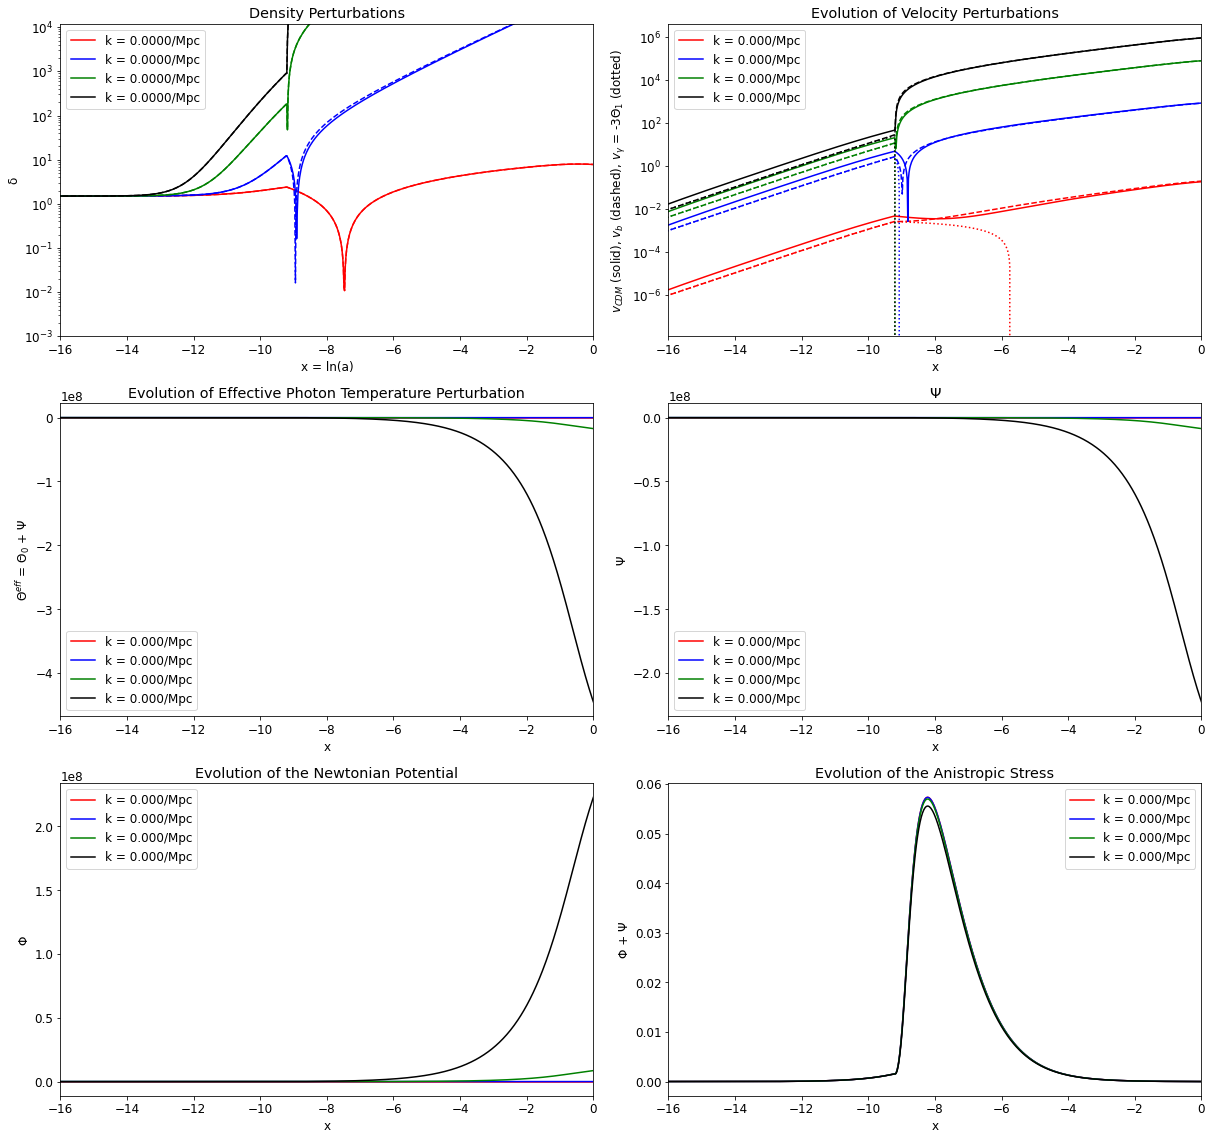

In [23]:
#kvals = [.0001, .001, .01, .1]
kvals = [ks[0], ks[32], ks[66], ks[-1]]
plot(kvals)

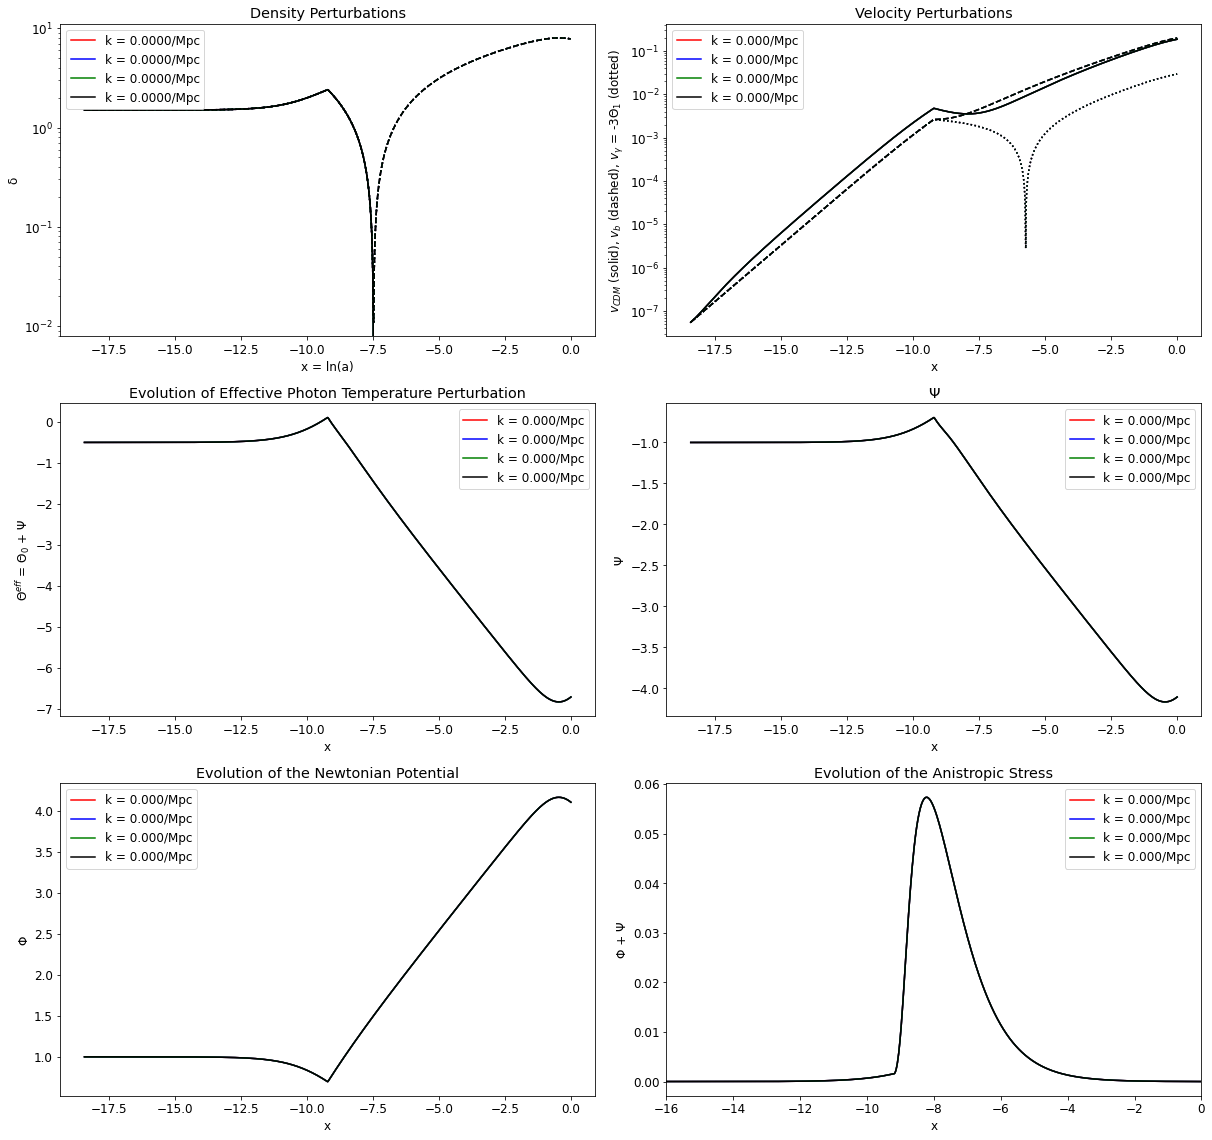

In [24]:
def plot(kvals):
    clr = ['r', 'b', 'g', 'k']
    
    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(17, 16))
    
    axs[0, 0].set_title('Density Perturbations')# k = ' + str(kmpc) + '/ Mpc')
    axs[0, 0].set_yscale('log')
    for i in range(len(kvals)):
        lb = 'k = ' + str('{:05.4f}'.format(kvals[i])) + '/Mpc'
        
        data_δ = δ_spl(x_grid, kvals[i])[:, 0]
        axs[0, 0].plot(x_grid, data_δ, color=clr[i], label=lb)
        
        data_δb = δb_spl(x_grid, kvals[i])[:, 0]
        axs[0, 0].plot(x_grid, np.abs(data_δb), color=clr[i], ls='--')
        
        data_Θ0 = Θ0_spl(x_grid, kvals[i])[:, 0]
        axs[0, 0].plot(x_grid, np.abs(3.0*data_Θ0), color=clr[i], ls=':')
    axs[0, 0].set_xlabel('x = ln(a)')
    axs[0, 0].set_ylabel('δ')
    axs[0, 0].legend()
    
    
    axs[0, 1].set_title('Velocity Perturbations')
    axs[0, 1].set_yscale('log')
    for i in range(len(kvals)):
        lb = 'k = ' + str('{:05.3f}'.format(kvals[i])) + '/Mpc'
        
        data_v = v_spl(x_grid, kvals[i])[:, 0]
        axs[0, 1].plot(x_grid, np.abs(data_v), color=clr[i], label=lb)
        
        data_vb = vb_spl(x_grid, kvals[i])[:, 0]
        axs[0, 1].plot(x_grid, np.abs(data_vb), color=clr[i], ls='--')
        
        data_Θ1 = Θ1_spl(x_grid, kvals[i])[:, 0]
        axs[0, 1].plot(x_grid, np.abs(-3.0*data_Θ1), color=clr[i], ls=':')
    axs[0, 1].set_xlabel('x')
    axs[0, 1].set_ylabel('$v_{CDM}$ (solid), $v_{b}$ (dashed), $v_{\gamma}$ = -3$Θ_1$ (dotted)')
    axs[0, 1].legend()
    
    
    axs[1, 0].set_title('Evolution of Effective Photon Temperature Perturbation')
    for i in range(len(kvals)):
        lb = 'k = ' + str('{:05.3f}'.format(kvals[i])) + '/Mpc'
        
        data_Ψ = Ψ_spl(x_grid, kvals[i])[:, 0]
        data_Θ0 = Θ0_spl(x_grid, kvals[i])[:, 0]
        axs[1, 0].plot(x_grid, data_Θ0 + data_Ψ, color=clr[i], label=lb)
    axs[1, 0].set_xlabel('x')
    axs[1, 0].set_ylabel('$Θ^{eff}$ = $Θ_0$ + Ψ')
    axs[1, 0].legend()
    
    axs[1, 1].set_title('Ψ')
    for i in range(len(kvals)):
        lb = 'k = ' + str('{:05.3f}'.format(kvals[i])) + '/Mpc'
        
        data_Ψ = Ψ_spl(x_grid, kvals[i])[:, 0]
        axs[1, 1].plot(x_grid, data_Ψ, color=clr[i], label=lb)
    axs[1, 1].set_xlabel('x')
    axs[1, 1].set_ylabel('Ψ')
    axs[1, 1].legend()
    
    axs[2, 0].set_title('Evolution of the Newtonian Potential')
    for i in range(len(kvals)):
        lb = 'k = ' + str('{:05.3f}'.format(kvals[i])) + '/Mpc'
        data_Φ = Φ_spl(x_grid, kvals[i])[:, 0]
        axs[2, 0].plot(x_grid, data_Φ, color=clr[i], label=lb)
    axs[2, 0].set_xlabel('x')
    axs[2, 0].set_ylabel('Φ')
    axs[2, 0].legend()
    
    axs[2, 1].set_title('Evolution of the Anistropic Stress')
    axs[2, 1].set_xlim(-16, 0)
    for i in range(len(kvals)):
        lb = 'k = ' + str('{:05.3f}'.format(kvals[i])) + '/Mpc'
        data_Ψ = Ψ_spl(x_grid, kvals[i])[:, 0]
        data_Φ = Φ_spl(x_grid, kvals[i])[:, 0]
        axs[2, 1].plot(x_grid, data_Ψ + data_Φ, color=clr[i], label=lb)
    axs[2, 1].set_xlabel('x')
    axs[2, 1].set_ylabel('Φ + Ψ')
    axs[2, 1].legend()
    
    fig.tight_layout()
    plt.show()
    
kvals = [ks[0]*m2Mpc, ks[32]*m2Mpc, ks[66]*m2Mpc, ks[-1]*m2Mpc]
plot(kvals)